In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import torch
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
dir_name = "Omni Spatial and Temporal Data/"
min_delay_dataset = LoadDataSet(dir_name)
print(f"Random shuffling state: {min_delay_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = min_delay_dataset.get_datasets(scale=True, scaler=scaler)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

data_dir = os.path.abspath("../../"+dir_name)
toa_tensor_def = sio.loadmat(os.path.join(data_dir, "all_toa_tensor"))['toa_tensor']

bool_m = toa_tensor_def == min_delay_dataset.toa_tensor_compare
print(np.all(bool_m))  # sanity check that the data corresponding to the min_toa path is selected correctly

The shape of the feature data is (150000, 4, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 6)
The shape of the testing data is: (75000, 4, 6)
new training shape: (75000, 24)
True


In [7]:
in_dim = min_delay_dataset.input_shape
out_dim = min_delay_dataset.output_shape
layers_dim = [in_dim, in_dim*2, in_dim*2, in_dim*2, out_dim]
dnn_model = DenseNet(layers_dim)
dnn_model.to(device)
summary(dnn_model, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), amsgrad=True)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 48]               1,200
|    └─Linear: 2-2                       [-1, 1, 48]               2,352
|    └─Linear: 2-3                       [-1, 1, 48]               2,352
|    └─Linear: 2-4                       [-1, 1, 3]                147
Total params: 6,051
Trainable params: 6,051
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02


In [8]:
def train_model(model=None, n_epochs=200):
    # train the model
    train_loss_history = []
    test_loss_history = []

    for epoch in range(n_epochs):
        total_train_loss = 0
        total_test_loss = 0
        total_train = 0
        total_test = 0

        # training loop (iterate over the training set)
        for x, y in train_dl:
            x_train, y_train = x.float().to(device), y.float().to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            train_output = model(x_train) # network output
            loss = Loss(train_output, y_train) # compute loss
            loss.backward() # compute gradient with respect to trainable parameters
            optimizer.step() # weights update
            total_train_loss += loss.item()
            total_train += 1

        print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
        # append training loss for the epoch
        train_loss_history.append(total_train_loss/total_train)

        # testing every 10 training epochs
        if ((epoch+1) % 10) == 0:
            for x, y in test_dl:
                x_test, y_test = x.float().to(device), y.float().to(device)
                test_output = model(x_test)
                loss = Loss(test_output, y_test)
                total_test_loss += loss.item()
                total_test += 1
            print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
            # append test loss for the epoch
            test_loss_history.append(total_test_loss/total_test)

    print('Finished Training')
    return train_loss_history, test_loss_history

In [9]:
epochs = 300
train_model(model=dnn_model, n_epochs=epochs)
torch.save(dnn_model.state_dict(), "../models/dnn_model_min_delay_v3")

Training at epoch: 1 ended, Loss: 1787.1791803983292
Training at epoch: 2 ended, Loss: 34.86498188057043
Training at epoch: 3 ended, Loss: 21.221980891130077
Training at epoch: 4 ended, Loss: 16.09716982778429
Training at epoch: 5 ended, Loss: 13.19733549832484
Training at epoch: 6 ended, Loss: 11.188080008831447
Training at epoch: 7 ended, Loss: 9.768222453193452
Training at epoch: 8 ended, Loss: 8.754940028076692
Training at epoch: 9 ended, Loss: 8.008660907122868
Training at epoch: 10 ended, Loss: 7.392791446717933
--> Testing at epoch: 10 ended, Loss: 7.098536426956589
Training at epoch: 11 ended, Loss: 6.9026432726977225
Training at epoch: 12 ended, Loss: 6.503839444127506
Training at epoch: 13 ended, Loss: 6.131293840070633
Training at epoch: 14 ended, Loss: 5.822884238773239
Training at epoch: 15 ended, Loss: 5.552465665157338
Training at epoch: 16 ended, Loss: 5.316933146668376
Training at epoch: 17 ended, Loss: 5.0984093011341
Training at epoch: 18 ended, Loss: 4.9105263924791

Training at epoch: 140 ended, Loss: 1.2749996030823973
--> Testing at epoch: 140 ended, Loss: 1.3198543142628025
Training at epoch: 141 ended, Loss: 1.269213841255411
Training at epoch: 142 ended, Loss: 1.2567794246808863
Training at epoch: 143 ended, Loss: 1.2660835782390203
Training at epoch: 144 ended, Loss: 1.2550562516922836
Training at epoch: 145 ended, Loss: 1.249174794671682
Training at epoch: 146 ended, Loss: 1.252248502924479
Training at epoch: 147 ended, Loss: 1.2354972926779004
Training at epoch: 148 ended, Loss: 1.2370680376455034
Training at epoch: 149 ended, Loss: 1.2264933173032955
Training at epoch: 150 ended, Loss: 1.2287035899383012
--> Testing at epoch: 150 ended, Loss: 1.2841136624684204
Training at epoch: 151 ended, Loss: 1.2221902371495454
Training at epoch: 152 ended, Loss: 1.2152559268113492
Training at epoch: 153 ended, Loss: 1.2144416476577622
Training at epoch: 154 ended, Loss: 1.218689309032602
Training at epoch: 155 ended, Loss: 1.198615031259662
Training 

Training at epoch: 275 ended, Loss: 0.8878039046232
Training at epoch: 276 ended, Loss: 0.8879364197851245
Training at epoch: 277 ended, Loss: 0.892766668095727
Training at epoch: 278 ended, Loss: 0.8811380658807303
Training at epoch: 279 ended, Loss: 0.8854275831425048
Training at epoch: 280 ended, Loss: 0.8837957371839993
--> Testing at epoch: 280 ended, Loss: 0.9560137036684397
Training at epoch: 281 ended, Loss: 0.878468431913812
Training at epoch: 282 ended, Loss: 0.8833854266731609
Training at epoch: 283 ended, Loss: 0.8791979587678209
Training at epoch: 284 ended, Loss: 0.8787488192574155
Training at epoch: 285 ended, Loss: 0.8721127073715979
Training at epoch: 286 ended, Loss: 0.8713648684017691
Training at epoch: 287 ended, Loss: 0.8764940201091889
Training at epoch: 288 ended, Loss: 0.8766509733598286
Training at epoch: 289 ended, Loss: 0.8682832894942154
Training at epoch: 290 ended, Loss: 0.8611103792836947
--> Testing at epoch: 290 ended, Loss: 0.9663849803241523
Training 

In [3]:
in_dim = min_delay_dataset.input_shape
out_dim = min_delay_dataset.output_shape
layers_dim = [in_dim, in_dim*2, in_dim*2, in_dim*2, out_dim]
dnn_model = DenseNet(layers_dim)
dnn_model.to(device)
dnn_model.load_state_dict(torch.load("../models/dnn_model_min_delay_v3"))

# evaluate the model over the entire data and the test data
train_error = []
test_error = []
all_error = []

for xx, yy in train_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error.extend(error)
    train_error.extend(error)

for xx, yy in test_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error.extend(error)
    test_error.extend(error)

train_error = np.array(train_error)
test_error = np.array(test_error)
all_error = np.array(all_error)

In [5]:
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [12]:
in_dim = all_paths_dataset.input_shape
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_all_paths = DenseNet(layers_dim)
dnn_model_all_paths.to(device)
summary(dnn_model_all_paths, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_all_paths.parameters(), amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              153,856
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.65
Estimated Total Size (MB): 0.66


In [37]:
# train the model
train_loss_history = []
test_loss_history = []

for epoch in range(200):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_all_paths(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_all_paths(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 0.24351692926329355
Training at epoch: 2 ended, Loss: 0.22536540968953903
Training at epoch: 3 ended, Loss: 0.25171498694288647
Training at epoch: 4 ended, Loss: 0.19519713674369985
Training at epoch: 5 ended, Loss: 0.2400540012338615
Training at epoch: 6 ended, Loss: 0.21730976752498196
Training at epoch: 7 ended, Loss: 0.24354467863127996
Training at epoch: 8 ended, Loss: 0.2360339954435037
Training at epoch: 9 ended, Loss: 0.2014892561418408
Training at epoch: 10 ended, Loss: 0.2359370133957155
--> Testing at epoch: 10 ended, Loss: 1.604369408375508
Training at epoch: 11 ended, Loss: 0.19893481068745408
Training at epoch: 12 ended, Loss: 0.2512045467793687
Training at epoch: 13 ended, Loss: 0.2132957461464883
Training at epoch: 14 ended, Loss: 0.23372462800141336
Training at epoch: 15 ended, Loss: 0.2508550086773856
Training at epoch: 16 ended, Loss: 0.21135586220771074
Training at epoch: 17 ended, Loss: 0.21320530441319474
Training at epoch: 18 end

Training at epoch: 137 ended, Loss: 0.20778641575127332
Training at epoch: 138 ended, Loss: 0.27488644217353936
Training at epoch: 139 ended, Loss: 0.17776480060604755
Training at epoch: 140 ended, Loss: 0.18710489701098246
--> Testing at epoch: 140 ended, Loss: 1.359949393449603
Training at epoch: 141 ended, Loss: 0.2234882511001449
Training at epoch: 142 ended, Loss: 0.22024994396760347
Training at epoch: 143 ended, Loss: 0.27886355876503033
Training at epoch: 144 ended, Loss: 0.19492961243494278
Training at epoch: 145 ended, Loss: 0.17524857402845911
Training at epoch: 146 ended, Loss: 0.22395784188373452
Training at epoch: 147 ended, Loss: 0.2102837358941499
Training at epoch: 148 ended, Loss: 0.21951249553806088
Training at epoch: 149 ended, Loss: 0.20563494480841193
Training at epoch: 150 ended, Loss: 0.22798984794505575
--> Testing at epoch: 150 ended, Loss: 1.3762688584424354
Training at epoch: 151 ended, Loss: 0.19941667588618378
Training at epoch: 152 ended, Loss: 0.229883377

In [32]:
torch.save(dnn_model_all_paths.state_dict(), "../models/dnn_model_all_paths_v3")

In [7]:
in_dim = all_paths_dataset.input_shape
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_all_paths = DenseNet(layers_dim)
dnn_model_all_paths.to(device)
dnn_model_all_paths.load_state_dict(torch.load("../models/dnn_model_all_paths_v3"))

# evaluate the model over the entire data and the test data
train_error_all_paths = []
test_error_all_paths = []
all_error_all_paths = []

for xx, yy in train_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_all_paths(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_all_paths.extend(error)
    all_error_all_paths.extend(error)

for xx, yy in test_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_all_paths(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_all_paths.extend(error)
    test_error_all_paths.extend(error)

train_error_all_paths = np.array(train_error_all_paths)
test_error_all_paths = np.array(test_error_all_paths)
all_error_all_paths = np.array(all_error_all_paths)

In [8]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [20]:
hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
print(hashim_baseline.shape)

(150000,)


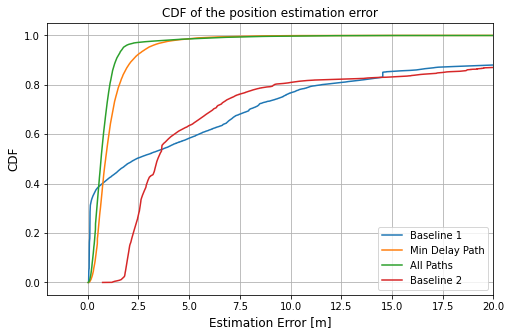

In [22]:
import tikzplotlib

figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error), np.linspace(0,1,len(all_error)), 
       np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), np.sort(hashim_baseline), np.linspace(0,1,len(hashim_baseline)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")
plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "Min Delay Path", "All Paths", "Baseline 2"], loc="lower right")

tikzplotlib.save("dnn_vs_baseline_hash_baseline.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [18]:
print(f"The average error for the Baseline is {np.mean(baseline_error)}")
print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

The average error for the Baseline is 18.359439931346508
The average error for Hashim Baseline is 10.12156626704354
The average error for the Min Delay DNN is 1.172646164894104
The average error for the All Paths DNN is 0.8733026385307312
